In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import VGG16
import efficientnet
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, Model # Model : 입력과출력만 넣어주면됌
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import cv2 as cv   # opencv (이미지 resize)

2022-05-09 09:39:00.987711: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/ubuntu/anaconda3/envs/machine_TF2_20/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
# import pandas as pd
# train_df = pd.read_csv("./data/train_df.csv")
# label_list = sorted(train_df["label"].unique().tolist())
# print(label_list)

In [3]:
train_dir = './data/train_full/train'
valid_dir = './data/train_full/validation'



IMAGE_SIZE = 256  # Image 크기 256x256
BATCH_SIZE = 8   # ImageGenerator가 한번에 가져오는 개수
LEARNING_RATE = 5e-5

# ImageDataGenerator를 위한 전처리 함수
# 여기서의 역할은 이미지 resize
def generate_preprocessing(img):
    # 여러가지 작업이 포함될 수 있어요
    img = cv.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

# ImageDataGenerator부터 만들어요
# train data는 augmentation 해서 생성할 꺼예요!
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=generate_preprocessing,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=generate_preprocessing,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
#                                                     classes = label_list,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=BATCH_SIZE,
#                                                     classes = label_list,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 2788 images belonging to 88 classes.
Found 1489 images belonging to 88 classes.


In [4]:
labels = train_generator.class_indices.keys()
labels = list(labels)

## Efficient1 학습

In [5]:
# Pretrained Network
pretrained_network = efn.EfficientNetB4(weights='imagenet',
                                        include_top=False,
                                        input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                                        classes=88)

pretrained_network.trainable = False # 학습이 안되게끔 동결처리


'''model = Sequential()

model.add(pretrained_network)

model.add(GlobalAveragePooling2D())

model.add(Dense(units=88,
                activation='softmax'))'''

model= Sequential()
model.add(pretrained_network) 
model.add(Flatten()) 
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
# model.add(Dense(512,activation=('relu'))) 
# model.add(Dense(256,activation=('relu'))) 
# # model.add(Dropout(.3))
# model.add(Dense(128,activation=('relu')))
# # model.add(Dropout(.2))
model.add(Dense(88,activation=('softmax'))) 

# Early Stopping
es = EarlyStopping(monitor='val_loss',
                   mode='auto',
                   patience=5,  # n번 연속으로 값이 떨어지지 않으면
                   verbose=1)

# Checkpoint
model_checkpoint = './ckpt/efficientnet_{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.ckpt'

checkpointer = ModelCheckpoint(filepath=model_checkpoint,
                               verbose=1,
                               period=2,
                               save_best_weights=True,
                               mode='auto',
                               monitor='val_acc')

'''
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
'''

model.compile(
    optimizer="adadelta",
    loss='categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(train_generator,
                    steps_per_epoch=(2788//BATCH_SIZE),
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=(1489//BATCH_SIZE),
                    callbacks=[es, checkpointer],
                    verbose=1)


# print(pretrained_network.summary())
# for idx, layer in enumerate(pretrained_network.layers):
#     print(f'{idx}번 :  {layer.name}')

2022-05-09 09:42:35.534021: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-09 09:42:35.535118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-09 09:42:35.599325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 09:42:35.599919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-09 09:42:35.599942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-09 09:42:35.665945: I tensorflow/stream_executor/platform/default/dso_loade

2022-05-09 09:42:42.115654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-09 09:42:42.135380: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/30


2022-05-09 09:42:50.461465: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-09 09:42:51.054713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


348/348 [==============================] - 223s 610ms/step - loss: 2.3464 - acc: 0.5987 - val_loss: 1.2694 - val_acc: 0.8185
Epoch 2/30
348/348 [==============================] - 197s 566ms/step - loss: 0.9249 - acc: 0.8732 - val_loss: 1.1557 - val_acc: 0.8199

Epoch 00002: saving model to ./ckpt/efficientnet_000002-0.819892-0.862590.ckpt


2022-05-09 09:49:59.567573: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./ckpt/efficientnet_000002-0.819892-0.862590.ckpt/assets
Epoch 3/30
348/348 [==============================] - 197s 566ms/step - loss: 0.8813 - acc: 0.8653 - val_loss: 1.0666 - val_acc: 0.8206
Epoch 4/30
348/348 [==============================] - 197s 567ms/step - loss: 0.8695 - acc: 0.8605 - val_loss: 0.9686 - val_acc: 0.8199

Epoch 00004: saving model to ./ckpt/efficientnet_000004-0.819892-0.864748.ckpt
INFO:tensorflow:Assets written to: ./ckpt/efficientnet_000004-0.819892-0.864748.ckpt/assets
Epoch 5/30
348/348 [==============================] - 197s 566ms/step - loss: 0.7996 - acc: 0.8585 - val_loss: 0.9340 - val_acc: 0.8206
Epoch 6/30
348/348 [==============================] - 197s 566ms/step - loss: 0.7341 - acc: 0.8606 - val_loss: 0.9116 - val_acc: 0.8199

Epoch 00006: saving model to ./ckpt/efficientnet_000006-0.819892-0.865827.ckpt
INFO:tensorflow:Assets written to: ./ckpt/efficientnet_000006-0.819892-0.865827.ckpt/assets
Epoch 7/30
348/348 [

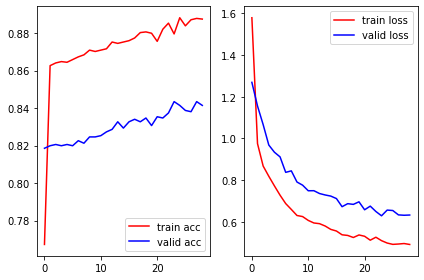

In [6]:
### history 객체를 이용해서 결과 그래프를 그려 보아요! ###

import matplotlib.pyplot as plt

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train acc')
ax1.plot(valid_acc, color='b', label='valid acc')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()

## Efficient 1 저장

In [7]:
#Print the Target names
target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

print(target_names)

['bottle-broken_large', 'bottle-broken_small', 'bottle-contamination', 'bottle-good', 'cable-bent_wire', 'cable-cable_swap', 'cable-combined', 'cable-cut_inner_insulation', 'cable-cut_outer_insulation', 'cable-good', 'cable-missing_cable', 'cable-missing_wire', 'cable-poke_insulation', 'capsule-crack', 'capsule-faulty_imprint', 'capsule-good', 'capsule-poke', 'capsule-scratch', 'capsule-squeeze', 'carpet-color', 'carpet-cut', 'carpet-good', 'carpet-hole', 'carpet-metal_contamination', 'carpet-thread', 'grid-bent', 'grid-broken', 'grid-glue', 'grid-good', 'grid-metal_contamination', 'grid-thread', 'hazelnut-crack', 'hazelnut-cut', 'hazelnut-good', 'hazelnut-hole', 'hazelnut-print', 'leather-color', 'leather-cut', 'leather-fold', 'leather-glue', 'leather-good', 'leather-poke', 'metal_nut-bent', 'metal_nut-color', 'metal_nut-flip', 'metal_nut-good', 'metal_nut-scratch', 'pill-color', 'pill-combined', 'pill-contamination', 'pill-crack', 'pill-faulty_imprint', 'pill-good', 'pill-pill_type',

In [8]:
import itertools
from sklearn.metrics import confusion_matrix,classification_report

#Confution Matrix 
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [9]:
#Print Classification Report
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Classification Report
                            precision    recall  f1-score   support

       bottle-broken_large       0.80      1.00      0.89         4
       bottle-broken_small       1.00      0.50      0.67         4
      bottle-contamination       0.00      0.00      0.00         4
               bottle-good       0.93      1.00      0.97        70
           cable-bent_wire       0.00      0.00      0.00         3
          cable-cable_swap       0.00      0.00      0.00         3
            cable-combined       0.00      0.00      0.00         3
cable-cut_inner_insulation       0.00      0.00      0.00         3
cable-cut_outer_insulation       0.00      0.00      0.00         2
                cable-good       0.79      1.00      0.88        75
       cable-missing_cable       1.00      0.33      0.50         3
        cable-missing_wire       0.00      0.00      0.00         2
     cable-poke_insulation       0.00      0.00      0.00         2
             capsule-crac

/home/ubuntu/anaconda3/envs/machine_TF2_20/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/machine_TF2_20/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/machine_TF2_20/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [10]:
#Save the model
model.save("./model/ad_efficient1.hdf5")

## Predict1

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt

submission_df = pd.read_csv('./data/sample_submission.csv', index_col='index')
test_df = pd.read_csv('./data/test_df.csv', index_col='index')

dir_path = './data/test'

In [12]:
from PIL import Image
import numpy as np

i = 0
for num, f_name, label in zip(range(len(test_df)) ,test_df['file_name'], submission_df['label']):
#     print(num, f_name, label)
    try:
        print('-1-', i)
        image_path = os.path.join(dir_path, f_name)
        image_path = image_path.replace('\\','/')
        image = Image.open(image_path)
        image = image.resize((256,256,3))
        image = np.array(image)
        x_test = np.array([image])
        x_test = (x_test)/255
        y_predict = model.predict(x_test)
        label = target_names[y_predict[0].argmax()]
        submission_df.iloc[num]['label'] = label
        
    except:
        try :
            print('-2-', i)
            image_path = os.path.join(dir_path, f_name)
            image_path = image_path.replace('\\','/')
            image = Image.open(image_path)
            image = image.resize((256,256))
            image = np.array(image)
            x_test = np.array([image])
            x_test = (x_test)/255
            y_predict = model.predict(x_test)
            label = target_names[y_predict[0].argmax()]
            submission_df.iloc[num]['label'] = label
        except:
            print(num, f_name)
        
display(submission_df)

-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
12 20012.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
23 20023.png
-1-
-2-
-1-
-2-
25 20025.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
34 20034.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
48 20048.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
63 20063.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
89 20089.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
94 20094.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


120 20120.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
129 20129.png
-1-
-2-
130 20130.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
144 20144.png
-1-
-2-
-1-
-2-
-1-
-2-
147 20147.png
-1-
-2-
148 20148.png
-1-
-2-
-1-
-2-
150 20150.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
161 20161.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
168 20168.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
177 20177.png
-1-
-2-
-1-
-2-
179 20179.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
195 20195.png
-1-
-2-


196 20196.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
209 20209.png
-1-
-2-
-1-
-2-
-1-
-2-
212 20212.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
221 20221.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
231 20231.png
-1-
-2-
232 20232.png
-1-
-2-
-1-
-2-
234 20234.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
242 20242.png
-1-
-2-
243 20243.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
267 20267.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
271 20271.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


279 20279.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
286 20286.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
295 20295.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
304 20304.png
-1-
-2-
-1-
-2-
-1-
-2-
307 20307.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
321 20321.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
326 20326.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
338 20338.png
-1-
-2-
-1-
-2-
-1-
-2-
341 20341.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
371 20371.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
385 20385.pn

421 20421.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
431 20431.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
447 20447.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
456 20456.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
481 20481.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
493 20493.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
499 20499.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
515 20515.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
525 20525.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1

556 20556.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
566 20566.png
-1-
-2-
567 20567.png
-1-
-2-
-1-
-2-
569 20569.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
576 20576.png
-1-
-2-
-1-
-2-
578 20578.png
-1-
-2-
579 20579.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
593 20593.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
611 20611.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
617 20617.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
654 20654.png
-1-
-2-
-1-
-2-


656 20656.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
665 20665.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
688 20688.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
692 20692.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
766 20766.png
-1-
-2-
767 20767.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-


797 20797.png
-1-
-2-
-1-
-2-
-1-
-2-
800 20800.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
809 20809.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
813 20813.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
819 20819.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
834 20834.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
842 20842.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
852 20852.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
863 20863.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
868 20868.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
886 20886.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


891 20891.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
897 20897.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
902 20902.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
911 20911.png
-1-
-2-
912 20912.png
-1-
-2-
-1-
-2-
-1-
-2-
915 20915.png
-1-
-2-
-1-
-2-
917 20917.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
923 20923.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
961 20961.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
979 20979.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
986 20986.png
-1-
-2-
-1-
-2-
988 20988.png
-1-
-2-
989 20989.png
-1-
-2-
-1-
-2-


-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
996 20996.png
-1-
-2-
-1-
-2-
-1-
-2-
999 20999.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1015 21015.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1020 21020.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1029 21029.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1035 21035.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1047 21047.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1053 21053.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1058 21058.png
-1-
-2-
1059 21059.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1063 21063.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


1074 21074.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1092 21092.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1101 21101.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1106 21106.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1127 21127.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1149 21149.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1154 21154.png
-1-
-2-
-1-
-2-
-1-
-2-
1157 21157.png
-1-
-2-
-1-
-2-
1159 21159.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1165 21165.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1170 21170.png
-1-
-2-
-1-
-2-
-1-
-2-


1173 21173.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1197 21197.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1202 21202.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1209 21209.png
-1-
-2-
-1-
-2-
-1-
-2-
1212 21212.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1228 21228.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1234 21234.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1249 21249.png
-1-
-2-
-1-
-2-
1251 21251.png
-1-
-2-
1252 21252.png
-1-
-2-
-1-
-2-
-1-
-2-
1255 21255.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


1277 21277.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1282 21282.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1286 21286.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1311 21311.png
-1-
-2-
1312 21312.png
-1-
-2-
1313 21313.png
-1-
-2-
1314 21314.png
-1-
-2-
-1-
-2-
-1-
-2-
1317 21317.png
-1-
-2-
-1-
-2-
-1-
-2-
1320 21320.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1328 21328.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1343 21343.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


1350 21350.png
-1-
-2-
-1-
-2-
1352 21352.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1359 21359.png
-1-
-2-
1360 21360.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1371 21371.png
-1-
-2-
-1-
-2-
1373 21373.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1388 21388.png
-1-
-2-
1389 21389.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1398 21398.png
-1-
-2-
-1-
-2-
-1-
-2-
1401 21401.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1418 21418.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1426 21426.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


1434 21434.png
-1-
-2-
-1-
-2-
1436 21436.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1442 21442.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1456 21456.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1504 21504.png
-1-
-2-
1505 21505.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1535 21535.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-

-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1599 21599.png
-1-
-2-
-1-
-2-
-1-
-2-
1602 21602.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1612 21612.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1643 21643.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1649 21649.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1653 21653.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1658 21658.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1664 21664.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1668 21668.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1672 21672.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1679 21679.png
-1-
-2-
-1-
-2-


-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1690 21690.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1699 21699.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1716 21716.png
-1-
-2-
-1-
-2-
-1-
-2-
1719 21719.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1727 21727.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1738 21738.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1764 21764.png
-1-
-2-
1765 21765.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1773 21773.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1780 21780.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


1786 21786.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1793 21793.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1799 21799.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1803 21803.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1818 21818.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1835 21835.png
-1-
-2-
-1-
-2-
-1-
-2-
1838 21838.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1849 21849.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1861 21861.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1875 21875.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1883 21883.png
-1-
-2-
1884 21884.png
-1-
-2-


-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1892 21892.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1899 21899.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1910 21910.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1925 21925.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1943 21943.png
-1-
-2-
-1-
-2-
1945 21945.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1953 21953.png
-1-
-2-
-1-
-2-
1955 21955.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1966 21966.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1980 21980.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


1990 21990.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
1998 21998.png
-1-
-2-
1999 21999.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2005 22005.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2015 22015.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2030 22030.png
-1-
-2-
-1-
-2-
2032 22032.png
-1-
-2-
-1-
-2-
2034 22034.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2039 22039.png
-1-
-2-
-1-
-2-
-1-
-2-
2042 22042.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2052 22052.png
-1-
-2-
-1-
-2-
2054 22054.png
-1-
-2-
-1-
-2-
-1-
-2-


2057 22057.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2065 22065.png
-1-
-2-
-1-
-2-
-1-
-2-
2068 22068.png
-1-
-2-
-1-
-2-
2070 22070.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2074 22074.png
-1-
-2-
-1-
-2-
-1-
-2-
2077 22077.png
-1-
-2-
-1-
-2-
2079 22079.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2088 22088.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2115 22115.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2132 22132.png
-1-
-2-
2133 22133.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-


2140 22140.png
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
-1-
-2-
2147 22147.png
-1-
-2-
-1-
-2-
-1-
-2-
2150 22150.png
-1-
-2-
-1-
-2-
-1-
-2-
2153 22153.png


,label
index,
0,pill-color
1,grid-good
2,transistor-good
3,tile-glue_strip
4,tile-good
...,...
2149,tile-good
2150,tile-good
2151,grid-good


In [14]:
submission_df.to_csv('./data/submission/submission_efficient1_0509.csv')

## Efficient2 학습 : Fine

In [16]:
pretrained_network.trainable = True

model_checkpoint = './ckpt/efficientnet2_{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.ckpt'

checkpointer = ModelCheckpoint(filepath=model_checkpoint,
                               verbose=1,
                               period=2,
                               save_best_weights=True,
                               mode='auto',
                               monitor='val_acc')

model.compile(
    optimizer="adadelta",
    loss='categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(train_generator,
                    steps_per_epoch=(2788//BATCH_SIZE),
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=(1489//BATCH_SIZE),
                    callbacks=[es, checkpointer],
                    verbose=1)

Epoch 1/30
348/348 [==============================] - 216s 581ms/step - loss: 1.0004 - acc: 0.8209 - val_loss: 1.0397 - val_acc: 0.8185
Epoch 2/30
348/348 [==============================] - 201s 578ms/step - loss: 0.9821 - acc: 0.8313 - val_loss: 0.9794 - val_acc: 0.8098

Epoch 00002: saving model to ./ckpt/efficientnet2_000002-0.809812-0.836331.ckpt
INFO:tensorflow:Assets written to: ./ckpt/efficientnet2_000002-0.809812-0.836331.ckpt/assets
Epoch 3/30
348/348 [==============================] - 207s 595ms/step - loss: 0.9491 - acc: 0.8466 - val_loss: 0.9788 - val_acc: 0.8145
Epoch 4/30
348/348 [==============================] - 200s 576ms/step - loss: 0.9142 - acc: 0.8379 - val_loss: 0.9296 - val_acc: 0.8185

Epoch 00004: saving model to ./ckpt/efficientnet2_000004-0.818548-0.844245.ckpt
INFO:tensorflow:Assets written to: ./ckpt/efficientnet2_000004-0.818548-0.844245.ckpt/assets
Epoch 5/30
348/348 [==============================] - 202s 580ms/step - loss: 0.8501 - acc: 0.8568 - val_los

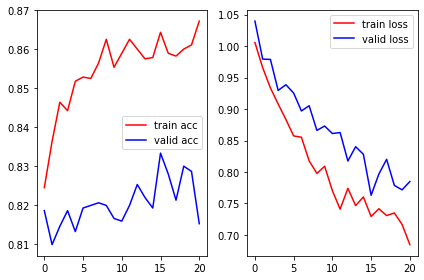

In [17]:
### history 객체를 이용해서 결과 그래프를 그려 보아요! ###

import matplotlib.pyplot as plt

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train acc')
ax1.plot(valid_acc, color='b', label='valid acc')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()

## efficient2 저장 : Fine

In [18]:
#Print the Target names
target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

print(target_names)

['bottle-broken_large', 'bottle-broken_small', 'bottle-contamination', 'bottle-good', 'cable-bent_wire', 'cable-cable_swap', 'cable-combined', 'cable-cut_inner_insulation', 'cable-cut_outer_insulation', 'cable-good', 'cable-missing_cable', 'cable-missing_wire', 'cable-poke_insulation', 'capsule-crack', 'capsule-faulty_imprint', 'capsule-good', 'capsule-poke', 'capsule-scratch', 'capsule-squeeze', 'carpet-color', 'carpet-cut', 'carpet-good', 'carpet-hole', 'carpet-metal_contamination', 'carpet-thread', 'grid-bent', 'grid-broken', 'grid-glue', 'grid-good', 'grid-metal_contamination', 'grid-thread', 'hazelnut-crack', 'hazelnut-cut', 'hazelnut-good', 'hazelnut-hole', 'hazelnut-print', 'leather-color', 'leather-cut', 'leather-fold', 'leather-glue', 'leather-good', 'leather-poke', 'metal_nut-bent', 'metal_nut-color', 'metal_nut-flip', 'metal_nut-good', 'metal_nut-scratch', 'pill-color', 'pill-combined', 'pill-contamination', 'pill-crack', 'pill-faulty_imprint', 'pill-good', 'pill-pill_type',

In [19]:
import itertools
from sklearn.metrics import confusion_matrix,classification_report

#Confution Matrix 
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [20]:
#Print Classification Report
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Classification Report
                            precision    recall  f1-score   support

       bottle-broken_large       0.00      0.00      0.00         4
       bottle-broken_small       1.00      0.25      0.40         4
      bottle-contamination       0.00      0.00      0.00         4
               bottle-good       0.90      1.00      0.95        70
           cable-bent_wire       0.00      0.00      0.00         3
          cable-cable_swap       0.00      0.00      0.00         3
            cable-combined       0.00      0.00      0.00         3
cable-cut_inner_insulation       0.00      0.00      0.00         3
cable-cut_outer_insulation       0.00      0.00      0.00         2
                cable-good       0.82      1.00      0.90        75
       cable-missing_cable       0.00      0.00      0.00         3
        cable-missing_wire       0.00      0.00      0.00         2
     cable-poke_insulation       0.00      0.00      0.00         2
             capsule-crac

/home/ubuntu/anaconda3/envs/machine_TF2_20/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/machine_TF2_20/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/machine_TF2_20/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [21]:
#Save the model
model.save("./model/ad_efficient2.h5")

## Predict2

In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt

submission_df = pd.read_csv('./data/sample_submission.csv', index_col='index')
test_df = pd.read_csv('./data/test_df.csv', index_col='index')

dir_path = './data/test'

In [ ]:
from PIL import Image
import numpy as np

i=0
for num, f_name, label in zip(range(len(test_df)) ,test_df['file_name'], submission_df['label']):
#     print(num, f_name, label)
    try:
        image_path = os.path.join(dir_path, f_name)
        image_path = image_path.replace('\\','/')
        image = Image.open(image_path)
        image = image.resize((256,256))
        image = np.array(image)
        x_test = np.array([image])
        x_test = (x_test)/255
        y_predict = model.predict(x_test)
        label = target_names[y_predict[0].argmax()]
        submission_df.iloc[num]['label'] = label
        i+=1
        
    except:
            try:
                image_path = os.path.join(dir_path, f_name)
                image_path = image_path.replace('\\','/')
                image = Image.open(image_path)
                image = image.resize((256,256))
                image = np.array(image)
                stacked_image = np.stack((image,)*3, axis=-1)
                x_test = np.array([stacked_image])
                x_test = (x_test)/255
                y_predict = model.predict(x_test)
                label = target_names[y_predict[0].argmax()]
                submission_df.iloc[num]['label'] = label
                i+=1
            
            except:
                print(num, f_name)
                i+=1
    
        
display(submission_df)

In [50]:
submission_df.to_csv('./data/submission/submission_efficient2_fixed_0509.csv')

In [ ]:
class_model
class_model.predict(test)
[bottle, transister....]
if bottle:
    bottle_model.predict(test)
    [bend, crack, ...]
elif transister:
    transister_model.predict(test)
    [bend, crack, ...]